# California Housing Dataset Regression

With the California housing dataset, my intention is to develop my skills further in data visualization and exploratory data analysis through more advanced plots, and become acquainted with regression problems. 

Moreover, this will be my first regression task project, and I hope to experiment a lot with linear models and different forms of regularization. The aim of this project is to predict Median House Value given a set of values

**Main Objectives and Tasks:**
- <u>Import the data</u>
- <u>Exploratory Data Analysis (EDA)</u>
- <u>Train/Validation/Test split</u>
- <u>Preprocess the data</u>
- <u>Fit and train the Linear Regression, LASSO, Ridge Regression, and Elastic Net models.</u>
- <u>Hyperparameter tuning.</u>
- <u>Evaluate on the test set.</u>

**Extra:**
- <u>Build the Linear Regression,  LASSO, and Ridge Regression models from scratch. </u>
- <u>MSE error implementation, closed form solution, and gradient descent optimization.</u>
- <u>Implement Mini-Batch Gradient Descent</u>

In [36]:
from sklearn.datasets import fetch_california_housing
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
housing = fetch_california_housing(as_frame=False)

## Linear, LASSO, and Ridge Regression Implementation

The aim of this section is to provide the manual implmementation of the following models:
- **Linear Regression**
- **LASSO**
- **Ridge Regression**

These models will be implemented with mini-batch gradient descent optimization, MSE loss, hyperparameters from the tuning, and closed-form solution computations for the best parameters.

A **linear regression** model takes the following form:
$$y = w^Tx + b$$

where w are the weights and b is the bias.

The cost function is the Mean Squared Error (MSE), which will be minimized, and is expressed in vectorized form (with **w** including the bias),
$$E_w = \frac{1}{2N}\|Xw - t\|^2_2$$

The direct (closed-form) solution is 
$$w = (X^TX)^{-1}X^Tt$$

The direct solution can be computationally expensive in high-dimensional settings, when the dimension d is large, due to the computation complexity of calculating $(X^TX)^{-1}$ being $O(d^3)$. Furthermore, $(X^TX)^{-1}$ may not be invertible, which complicates matters further. Therefore, using gradient descent is preferred, and the gradient descent update is
$$w \leftarrow w - α\nabla E_w$$

where $\nabla E_w = \frac{1}{N}X^T(Xw-t)$ is the gradient of the weights from the MSE.

Regularized linear models include a penalty term in the cost function to constrain the weights and prevent overfitting. Preferring models with smaller weights improves generalization on unseen data.

**LASSO** (Least Absolute Shrinkage and Selection Operator) includes an $L_1$ regularization term. With a high enough λ, weights are set to 0 and model selection can be conducted. The regularized cost function is the following:
$$J_w = E_w + λ\sum^n_{i=1}|w_i|$$

The gradient of the cost function is the following: 
$$\nabla J_w = \frac{1}{N}X^T(Xw - t)+λ\text{sign}(w)$$

where $
\text{sign}(w_i) = 
\begin{cases}
  1       & \text{if } x > 0 \\
  0        & \text{if } x = 0 \\
  -1        & \text{if } x < 0
\end{cases}$

**Ridge Regression** includes an $L_2$ regularization, and can shrink weights heavily with a high enough λ, but does not set them to 0 and so cannot be used for model selection. The regularization cost function for ridge regression is,
$$J_w = E_w + \frac{λ}{2}\sum^n_{i=1}w_i^2$$

The gradient of the cost function is,
$$\nabla J_w = \frac{1}{N}X^T(Xw - t)+λw$$

Due to the large number of training examples, mini-batch gradient descent will be implemented. Each epoch is a full pass through the training data, which will be split into a number of batches, whose size is specified beforehand. Each iteration will compute the gradient on one of these batches. For each epoch, the training data is shuffled and if there are not enough instances to create the last batch with the specified size, a smaller one will be created. 

The benefit of mini-batch gradient descent is that gradient computation is much faster as it is not done over the entire dataset, and so convergence happens much quicker. However, as a consequence, more variance is injected into the gradient computations. Smaller batch sizes can result in noisier gradients and less stable updates.


In [39]:
class LinearRegression():
    """
    This is a custom implementation of the Multiple Linear Regression model. Regularization can be specified turning the model
    into either LASSO or Ridge Regression.

    Parameters:
    - self.W are the weights used by the model (D x 1)
    - self.b is the bias term (1 x 1)
    - self.regularization specifies the kind of regularization 
    - self.lamb is the regularization term
    - self.batch_size is the size of mini batches for mini-batch gradient descent
    - self.gd determines the kind of gradient descent used ('mini', 'full', or 'none')
    - self.regularization determines the kind of regularization to be applied ('lasso', ridge' or 'none')

    Note setting gd to 'none' computes the closed-form solution of the linear regression algorithm.
    """
    def __init__(self, regularization=None, alpha=0.01, lamb=0.1, batch_size=32, gd="full", epochs=100):
        self.W = None
        self.b = None
        self.epochs = epochs
        self.batch_size = batch_size
        self.regularization=regularization
        self.lamb = lamb
        self.alpha=alpha
        self.gd = gd
        
    def fit(self, X, t):

        N = X.shape[0]
        D = X.shape[1]
        t = t.values.reshape(-1,  1)
        self.W = np.random.randn(D, 1)
        self.b = 0

        # Full batch
        if self.gd == 'full':
            for i in range(self.epochs+1):
                # Get the predictions
                y = X @ self.W + self.b 
            
                # Loss function calculation
                loss = self.loss(y, t, N)

                # Gradient Descent updatesd
                g = self.gradient_descent(y, t, X, N)

                if i % 10 == 0:
                    print("The MSE loss at epoch {0} is {1:.4f}".format(i, loss))

        # Mini batches
        elif self.gd == 'mini':
            for i in range(self.epochs+1):
                epoch_loss = 0
                # Shuffle Training Set - make sure all shuffle by same indices
                random_indices = np.random.permutation(N)
            
                X_shuffle = X[random_indices]
                t_shuffle = t[random_indices]

                batches = self.mini_batch(t_shuffle, X_shuffle, N)
                # Get mini-batches for training
                for key, value in batches.items():
                    x_batch = value[0]
                    t_batch = value[1]
            
                    # Get the predictions
                    y_batch = x_batch @ self.W + self.b 
            
                    # Loss function calculation
                    loss = self.loss(y_batch, t_batch, x_batch)
                    epoch_loss += loss
                    

                    # Gradient Descent updatesd
                    g = self.gradient_descent(y_batch, t_batch, x_batch)

                epoch_loss /= len(batches)

                if i % 10 == 0:
                    print("The MSE loss at epoch {0} is {1:.4f}".format(i, epoch_loss))
                
        # Closed form solution for a linear regression model without regularization
        elif self.gd == "none":
            self.W = np.linalg.inv(X.T @ X) @ X.T @ t

    def loss(self, y, t, X):
        n = X.shape[0]
            
        # Mean Squared Error loss
        if self.regularization == 'lasso':
            mse = (1/(2*n)) * np.sum((y - t)**2) + self.lamb*np.sum(np.absolute(self.W))
        elif self.regularization == 'ridge':
            mse = (1/(2*n)) * np.sum((y - t)**2) + (self.lamb/2) *np.sum(self.W**2)
        elif self.regularization == 'none':
            mse = (1/(2*n)) * np.sum((y - t)**2)
        
        return mse

    def mini_batch(self, t, X, N):
        batches = {}
        n_batches = N // self.batch_size
        # Create batches
        for i in range(n_batches):
            batches[i] = [X[i*self.batch_size:(i+1)*self.batch_size], t[i*self.batch_size:(i+1)*self.batch_size]]

        # Last batch should be compiled into its own batch, even if it's less than batch size
        if N % self.batch_size != 0 :
            batches[n_batches] = [X[n_batches*self.batch_size:], t[n_batches*self.batch_size:]]

        return batches

    def gradient_descent(self, y, t, X):
        n = X.shape[0]

        # Gradient updates for Weights and Bias parameters
        if self.regularization == 'none':
            self.W = self.W - self.alpha * (1/n) * (X.T @ (y - t))
            self.b = self.b - self.alpha * np.mean((y - t))
        elif self.regularization == 'ridge':
            self.W = self.W - self.alpha * ((1/n) * (X.T @ (y - t)) + self.lamb*self.W)
            self.b = self.b - self.alpha * np.mean((y - t))
        elif self.regularization == 'lasso':
            self.W = self.W - self.alpha * ((1/n) * (X.T @ (y - t)) + self.lamb*np.sign(self.W))
            self.b = self.b - self.alpha * np.mean((y - t))

    def predict(self, X):
        y = X @ self.W + self.b
        return y

## Exploratory Data Analysis (EDA)

In [41]:
housing.feature_names, housing.target

(['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]))

In [42]:
df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [43]:
targets = pd.DataFrame(data=housing.target, columns=["MedianHouseValue"])
data = pd.concat([df, targets], axis=1)
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [44]:
data.shape

(20640, 9)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MedInc            20640 non-null  float64
 1   HouseAge          20640 non-null  float64
 2   AveRooms          20640 non-null  float64
 3   AveBedrms         20640 non-null  float64
 4   Population        20640 non-null  float64
 5   AveOccup          20640 non-null  float64
 6   Latitude          20640 non-null  float64
 7   Longitude         20640 non-null  float64
 8   MedianHouseValue  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [46]:
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


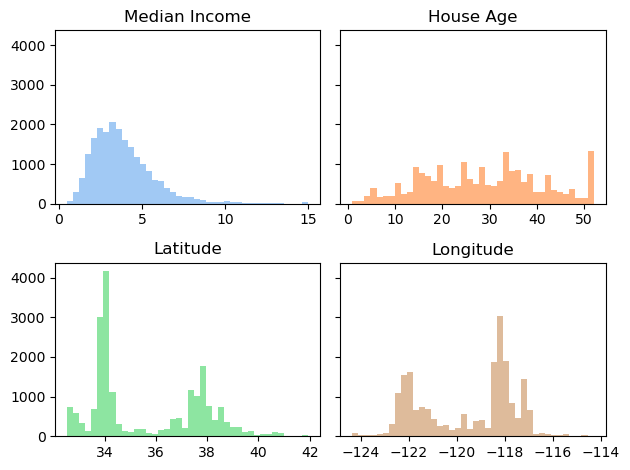

In [161]:
# Histograms
fig, axs = plt.subplots(2, 2, sharey = True, tight_layout=True)
features = ["MedInc", "HouseAge", "Latitude", "Longitude"]
features_names = ["Median Income", "House Age", "Latitude", "Longitude"]
colors = ["#A1C9F4", "#FFB482", "#8DE5A1", "#DEBB9B"]
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].hist(data[features[i]], bins=40, color=colors[i])
    axs[i].set_title(features_names[i])

In [48]:
# Correlation Matrix of Features
correlations = data.corr()
correlations["MedianHouseValue"].sort_values(ascending=False)[1:]

MedInc        0.688075
AveRooms      0.151948
HouseAge      0.105623
AveOccup     -0.023737
Population   -0.024650
Longitude    -0.045967
AveBedrms    -0.046701
Latitude     -0.144160
Name: MedianHouseValue, dtype: float64

Taking a look at Median House Value, it can easily be seen that it's highly correlated with Median Income, which is not surprising at all. Other features that appear to have some correlation with the target are the House Age, the Average Number of Rooms, and the Latitude. 

In order to verify the impact of geographical location on the housing prices and understand why this kind of influence exists, a scatter plot of latitude vs. longitude will be plotted to hopefully uncover insights.

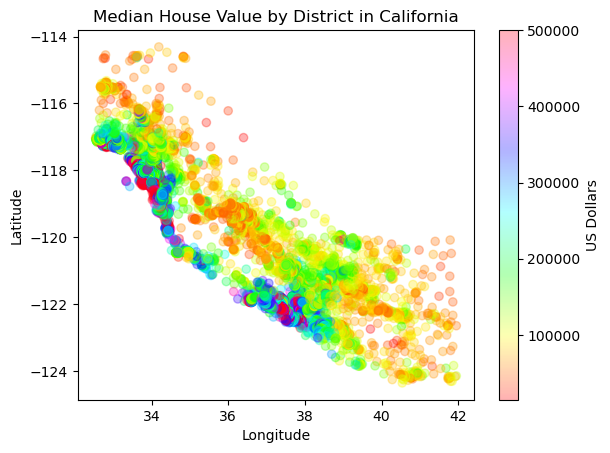

In [50]:
# Visualizing Geographical Data
plt.scatter(x=data["Latitude"], y=data["Longitude"], c=data["MedianHouseValue"]*100000, cmap="hsv", alpha=0.3)
plt.colorbar(label="US Dollars")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Median House Value by District in California")
plt.show()

From the graph, the districts with the largest median house value are all concentrated near the coast of California. This is to be expected, given the attractions of the warm weather, quality of life, entertainment and beaches. Hence Latitude may prove to be an important feature for predicting median house value.

This idea was personally reimplemented from the following book, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems* by Aurélien Géron, chapter 2.

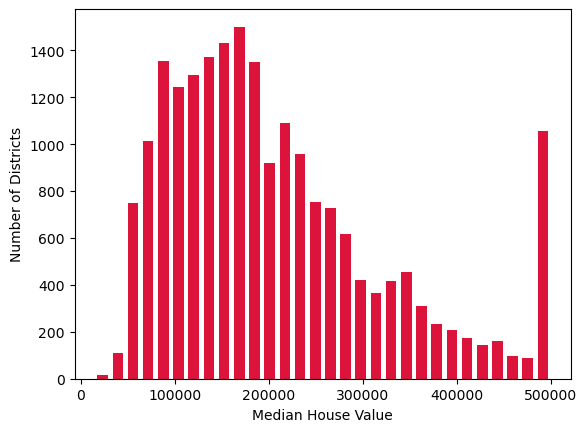

In [181]:
plt.hist(data["MedianHouseValue"]*100000, bins=30, color="crimson",rwidth=0.7)
plt.xlabel("Median House Value")
plt.ylabel("Number of Districts")
plt.show()

One unusual characteristic of median housing price is the high cutoff value at 500000, which indicates that any median housing prices > 500000 where capped at that value, which may be problematic for prediction. Aside from that, the distribution of median housing prices is not out of the ordinary.

Let's take a look at the most most correlated feature, Median Income, and see it's relation to the Median Housing Price with 

In [ ]:
# Visualizing Median Income on Median House Value
pd.plotting.scatter_matrix(data[["MedInc", "MedianHouseValue"]])
plt.show()

This provides a striking visualization of the close correlation between Median House Value and Median Income, at ~0.689. 

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
features = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude"]
X_train, X_test, y_train, y_test = train_test_split(data[features], data["MedianHouseValue"], test_size=0.2, train_size=0.8, shuffle=True, random_state=42)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
y_train.shape, y_test.shape

## Preprocess the Data

In [ ]:
# Scale the data to improve the model performance.
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)

In [ ]:
y_train

## Building the Model

The following models will now be built using sklearn, trained, validated, and then evaluated:
- Linear Regression
- Ridge Regression
- LASSO (Least Absolute Shrinkage and Selection Operator)
- ElasticNet

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Fit a Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

In [ ]:
lin_reg.coef_, lin_reg.intercept_

In [ ]:
# Fit a Ridge Regression Model
ridge = Ridge(alpha=1.0, tol=0.001)
ridge.fit(X_train_scaled, y_train)

In [ ]:
ridge.coef_, ridge.intercept_

In [ ]:
# Fit a LASSO Model
lasso = Lasso(alpha=0.1, tol=0.001)
lasso.fit(X_train_scaled, y_train)

In [ ]:
lasso.coef_, lasso.intercept_

In [ ]:
# Fit an ElasticNet Model
elastic = ElasticNet(alpha=0.01, tol=0.001)
elastic.fit(X_train_scaled, y_train)

In [ ]:
elastic.coef_, elastic.intercept_

## Hyperparameter Tuning 

Tune the hyperparameters (alpha and the tolerance) for the Ridge Regression, LASSO, and ElasticNet models using GridSearchCV. Through cross-fold validation, GridSearchCV chooses the best parameters in a specified grid to determine which ones are most optimal for the model's task.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {"alpha": [0.01, 0.1, 1.0, 10.0, 100.0], "tol": [0.0001, 0.001, 0.01]}

In [ ]:
# For LASSO
grid_search_LASSO = GridSearchCV(lasso, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search_LASSO.fit(X_train_scaled, y_train)

In [ ]:
# Get parameters
grid_search_LASSO.best_params_

In [ ]:
# For Ridge
grid_search_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search_ridge.fit(X_train_scaled, y_train)

In [ ]:
# Get parameters
grid_search_ridge.best_params_

In [ ]:
# For ElasticNet
grid_search_elastic = GridSearchCV(elastic, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search_elastic.fit(X_train_scaled, y_train)

In [ ]:
grid_search_elastic.best_params_

## Evaluation

Evaluate the performance of the models on the test set, determine if further enhancement is needed or their performance is satisfactory.

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# Linear Regression model
lr_preds = lin_reg.predict(X_test_scaled)
lr_scores = mean_squared_error(y_test, lr_preds)
lr_scores

In [ ]:
# LASSO
lasso_model = Lasso(alpha=0.01, tol=0.0001)
lasso_model.fit(X_train_scaled, y_train)
lasso_preds = lasso_model.predict(X_test_scaled)
lasso_scores = mean_squared_error(y_test, lasso_preds)
lasso_scores

In [ ]:
# Ridge Regression
ridge_model = Ridge(alpha=0.1, tol=0.0001)
ridge_model.fit(X_train_scaled, y_train)
ridge_preds = ridge_model.predict(X_test_scaled)
ridge_scores = mean_squared_error(y_test, ridge_preds)
ridge_scores

In [ ]:
# ElasticNet
elastic_model = ElasticNet(alpha=0.01, tol=0.0001)
elastic_model.fit(X_train_scaled, y_train)
elastic_preds = elastic_model.predict(X_test_scaled)
elastic_scores = mean_squared_error(y_test, elastic_preds)
elastic_scores

Given the results from evaluating on the test set, it appears that LASSO performs best, slightly outperforming ElasticNet, Ridge Regression, and Linear Regression models.

Therefore, it would be most appropriate, based off of this evaluation, to select LASSO for predicting median house value given our set of features.

In [ ]:
lasso.score(X_test_scaled, y_test)

With an R^2 of around 0.4814, it can be seen that approximately 50% of the variability in the targets is explained by the feature variables.

## Evaluating the Implemented Model

In [ ]:
model = LinearRegression(regularization='lasso', alpha=0.001, lamb=0.001, batch_size=32, gd="mini", epochs=100)
model.fit(X_train_scaled, y_train)

In [ ]:
preds = model.predict(X_test_scaled)
mean_squared_error(y_test, preds)

The implementations of the LASSO, Ridge, and Multiple Linear Regression model using Mean Squared Error (MSE) and Mini-Batch Gradient Descent for the California Housing Regression task to predict the Median House Value for the district provide similar MSEs to the sklearn models. 